In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Load dataset (replace with your dataset loading code)
data = pd.read_csv('diabetes.csv')

# Separate features and target
X = data.drop(columns=['Outcome'])
y = data['Outcome']

In [2]:
# Preprocess categorical features if any
# Example: Encoding categorical features
# label_encoder = LabelEncoder()
# X['categorical_column'] = label_encoder.fit_transform(X['categorical_column'])

In [3]:
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
# Standardize numerical features if needed
# scaler = StandardScaler()
# X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
# X_val[numerical_columns] = scaler.transform(X_val[numerical_columns])

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score, StratifiedKFold

# **Random Forest model**

In [6]:
# Define Random Forest model
def create_model(n_estimators, max_depth, min_samples_split):
    model = RandomForestClassifier(
        n_estimators=int(n_estimators),
        max_depth=int(max_depth),
        min_samples_split=min_samples_split,
        random_state=42,
        n_jobs=-1
    )
    return model


In [7]:
import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from skopt import gp_minimize

# **Bayesian Optimization**

In [8]:
# Define the search space for Bayesian Optimization
space = [
    (10, 1000),      # n_estimators
    (2, 20),         # max_depth
    (2, 50)          # min_samples_split
]

In [9]:
# Define the objective function for BO
def objective_function(params):
    n_estimators = params[0]
    max_depth = params[1]
    min_samples_split = params[2]
    
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        random_state=42,
        n_jobs=-1
    )
    
    # Cross-validation with StratifiedKFold
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    roc_auc_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc')
    cross_val_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    mean_roc_auc = np.mean(roc_auc_scores)
    mean_cross_val = np.mean(cross_val_scores)
    print("Cross Val Score with Bayesian Optimization: ",mean_cross_val)
    
    return -mean_roc_auc  # Minimize negative ROC AUC (BO maximizes)

In [10]:
# Perform Bayesian Optimization
res_gp = gp_minimize(objective_function, space, n_calls=20, random_state=42)

# Extract the best hyperparameters
best_hyperparams = {
    'n_estimators': res_gp.x[0],
    'max_depth': res_gp.x[1],
    'min_samples_split': res_gp.x[2]
}

print("Best hyperparameters:", best_hyperparams)

Cross Val Score with Bayesian Optimization:  0.767093162734906
Cross Val Score with Bayesian Optimization:  0.7655071304811408
Cross Val Score with Bayesian Optimization:  0.7687858190057311
Cross Val Score with Bayesian Optimization:  0.7622151139544182
Cross Val Score with Bayesian Optimization:  0.7345595095295214
Cross Val Score with Bayesian Optimization:  0.7622417699586832
Cross Val Score with Bayesian Optimization:  0.7687591630014661
Cross Val Score with Bayesian Optimization:  0.7687591630014661
Cross Val Score with Bayesian Optimization:  0.765480474476876
Cross Val Score with Bayesian Optimization:  0.7670798347327735
Cross Val Score with Bayesian Optimization:  0.7671331467413035
Cross Val Score with Bayesian Optimization:  0.7606024256963881
Cross Val Score with Bayesian Optimization:  0.7655071304811409
Cross Val Score with Bayesian Optimization:  0.765480474476876
Cross Val Score with Bayesian Optimization:  0.7638544582167134
Cross Val Score with Bayesian Optimization:

In [11]:
# Evaluate on validation set with best hyperparameters
best_model = create_model(best_hyperparams['n_estimators'],
                          best_hyperparams['max_depth'],
                          best_hyperparams['min_samples_split'])

# **ROC-AUC and Cross-val Score after Bayesian-optimization**

In [12]:
best_model.fit(X_train, y_train)
y_pred = best_model.predict_proba(X_val)[:, 1]
roc_auc_scores_bo = roc_auc_score(y_val, y_pred)
print(f"ROC AUC with optimized hyperparameters: {roc_auc_scores_bo}")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cross_val_scores = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='accuracy')
mean_cross_val = np.mean(cross_val_scores)
print("Cross Val Score with optimized hyperparameters: ",mean_cross_val)

# Compare with default parameters
default_model = RandomForestClassifier(random_state=42)
default_model.fit(X_train, y_train)
y_pred_default = default_model.predict_proba(X_val)[:, 1]
roc_auc_default = roc_auc_score(y_val, y_pred_default)
print(f"ROC AUC with default hyperparameters: {roc_auc_default}")
cross_val_scores = cross_val_score(default_model, X_train, y_train, cv=cv, scoring='accuracy')
mean_cross_val = np.mean(cross_val_scores)
print("Cross Val Score with default hyperparameters: ",mean_cross_val)

ROC AUC with optimized hyperparameters: 0.83544536271809
Cross Val Score with optimized hyperparameters:  0.7687858190057311
ROC AUC with default hyperparameters: 0.8120293847566575
Cross Val Score with default hyperparameters:  0.7736372117819539


# **Optimisation using hyperopt**

In [13]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, roc_auc_score
import numpy as np

In [14]:
def objective(params):
    clf = RandomForestClassifier(**params)
    score = cross_val_score(clf, X_train, y_train, scoring=make_scorer(roc_auc_score)).mean()
    return {'loss': -score, 'status': STATUS_OK, 'roc_auc_score': score}

In [15]:
space = {
    'n_estimators': hp.choice('n_estimators', range(10, 1000)),
    'max_depth': hp.choice('max_depth', range(2, 20)),
    'min_samples_split': hp.choice('min_samples_split', range(2, 50)),
}

In [16]:
trials = Trials()
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=20,
    trials=trials
)
# Extract all ROC-AUC scores
roc_auc_scores_hyperopt = [-trial['result']['loss'] for trial in trials.trials]

print("Best parameters by Bayesian Optimisation using hyperopt:", best)
print("All ROC-AUC scores:", roc_auc_scores_hyperopt)

100%|██████████| 20/20 [01:15<00:00,  3.80s/trial, best loss: -0.7347186846314753]
Best parameters by Bayesian Optimisation using hyperopt: {'max_depth': 12, 'min_samples_split': 16, 'n_estimators': 860}
All ROC-AUC scores: [0.7094319347032526, 0.7172615971453181, 0.731087732250523, 0.7206698863869406, 0.6626977974652393, 0.7256473278372504, 0.7115914031417908, 0.7287139063204954, 0.7323377322505229, 0.7344560826053074, 0.69751886715065, 0.7321633136458718, 0.7313811984742218, 0.7291192937123169, 0.7208443049915918, 0.7103085907058775, 0.7092575160986014, 0.7347186846314753, 0.6911856055945202, 0.6965152680365859]


In [17]:
# Evaluate on validation set with best hyperparameters
best_model = create_model(best['n_estimators'],
                          best['max_depth'],
                          best['min_samples_split'])

In [18]:
best_model.fit(X_train, y_train)
y_pred = best_model.predict_proba(X_val)[:, 1]
roc_auc_scores_hyper = roc_auc_score(y_val, y_pred)
print(f"ROC AUC Score using hyperopt: {roc_auc_scores_hyper}")

ROC AUC Score using hyperopt: 0.8350780532598715


# **tpe Optimization**

In [19]:
def objective_function(params):
    model = create_model(params['n_estimators'],
                         params['max_depth'],
                         params['min_samples_split'])
    
    # Cross-validation with StratifiedKFold
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    roc_auc_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc')
    cross_val_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    mean_roc_auc = np.mean(roc_auc_scores)
    mean_cross_val = np.mean(cross_val_scores)
    print("Cross Val Score with tpe Optimization: ",mean_cross_val)
    
    return -mean_roc_auc  # Minimize negative ROC AUC (TPE maximizes)

In [20]:
roc_auc_scores_tpe = []

def tpe_optimization(objective_function, space, n_calls):
    # Initialize lists to store hyperparameters and objective function values
    params = []
    results = []
    
    for _ in range(n_calls):
        # Sample hyperparameters from the search space
        next_params = {key: np.random.choice(values) for key, values in space.items()}
        
        # Evaluate objective function
        score = objective_function(next_params)
        
        # Store results
        params.append(next_params)
        results.append(score)
        roc_auc_scores_tpe.append(-score)
        
    # Get index of best result
    best_index = np.argmax(results)
    best_params = params[best_index]
    
    return best_params

In [21]:
# Define the search space
space = {
    'n_estimators': [10, 100, 500, 1000],
    'max_depth': [2, 5, 10, 20],
    'min_samples_split': [2, 5, 10, 20, 50]
}

In [22]:
# Perform optimization using TPE
best_hyperparams = tpe_optimization(objective_function, space, n_calls=20)

print("Best hyperparameters:", best_hyperparams)

Cross Val Score with tpe Optimization:  0.7573370651739304
Cross Val Score with tpe Optimization:  0.7361721977875516
Cross Val Score with tpe Optimization:  0.7345595095295214
Cross Val Score with tpe Optimization:  0.7377315740370519
Cross Val Score with tpe Optimization:  0.7703451952552312
Cross Val Score with tpe Optimization:  0.734546181527389
Cross Val Score with tpe Optimization:  0.7687458349993337
Cross Val Score with tpe Optimization:  0.7687724910035986
Cross Val Score with tpe Optimization:  0.765480474476876
Cross Val Score with tpe Optimization:  0.7312674930027988
Cross Val Score with tpe Optimization:  0.734546181527389
Cross Val Score with tpe Optimization:  0.7622550979608157
Cross Val Score with tpe Optimization:  0.7671064907370386
Cross Val Score with tpe Optimization:  0.7638677862188458
Cross Val Score with tpe Optimization:  0.7361855257896841
Cross Val Score with tpe Optimization:  0.7719712115153937
Cross Val Score with tpe Optimization:  0.734546181527389
C

In [23]:
# Evaluate on validation set with best hyperparameters
best_model = create_model(best_hyperparams['n_estimators'],
                          best_hyperparams['max_depth'],
                          best_hyperparams['min_samples_split'])

# **ROC-AUC and Cross-val Score after tpe-optimization**

In [24]:
best_model.fit(X_train, y_train)
y_pred = best_model.predict_proba(X_val)[:, 1]
roc_auc_scores_bo = roc_auc_score(y_val, y_pred)
print(f"ROC AUC with optimized hyperparameters: {roc_auc_scores_bo}")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cross_val_scores = cross_val_score(best_model, X_train, y_train, cv=cv, scoring='accuracy')
mean_cross_val = np.mean(cross_val_scores)
print("Cross Val Score with optimized hyperparameters: ",mean_cross_val)

# Compare with default parameters
default_model = RandomForestClassifier(random_state=42)
default_model.fit(X_train, y_train)
y_pred_default = default_model.predict_proba(X_val)[:, 1]
roc_auc_default = roc_auc_score(y_val, y_pred_default)
print(f"ROC AUC with default hyperparameters: {roc_auc_default}")
cross_val_scores = cross_val_score(default_model, X_train, y_train, cv=cv, scoring='accuracy')
mean_cross_val = np.mean(cross_val_scores)
print("Cross Val Score with default hyperparameters: ",mean_cross_val)

ROC AUC with optimized hyperparameters: 0.7491276400367309
Cross Val Score with optimized hyperparameters:  0.732880181260829
ROC AUC with default hyperparameters: 0.8120293847566575
Cross Val Score with default hyperparameters:  0.7736372117819539


# **Summary**

Best hyperparameters with Bayesian Optimisation: {'n_estimators': 465, 'max_depth': 8, 'min_samples_split': 9}

Best hyperparameters with tpe Optimisation:  {'n_estimators': 10, 'max_depth': 20, 'min_samples_split': 5}

Best parameters using hyperopt: {'max_depth': 12, 'min_samples_split': 16, 'n_estimators': 860}

ROC AUC Score with Bayesian Optimisation: 0.83544536271809

ROC AUC Score with tpe Optimisation: 0.7491276400367309

ROC AUC Score with using hyperopt: 0.8350780532598715

# **Learning Rate Distribution**

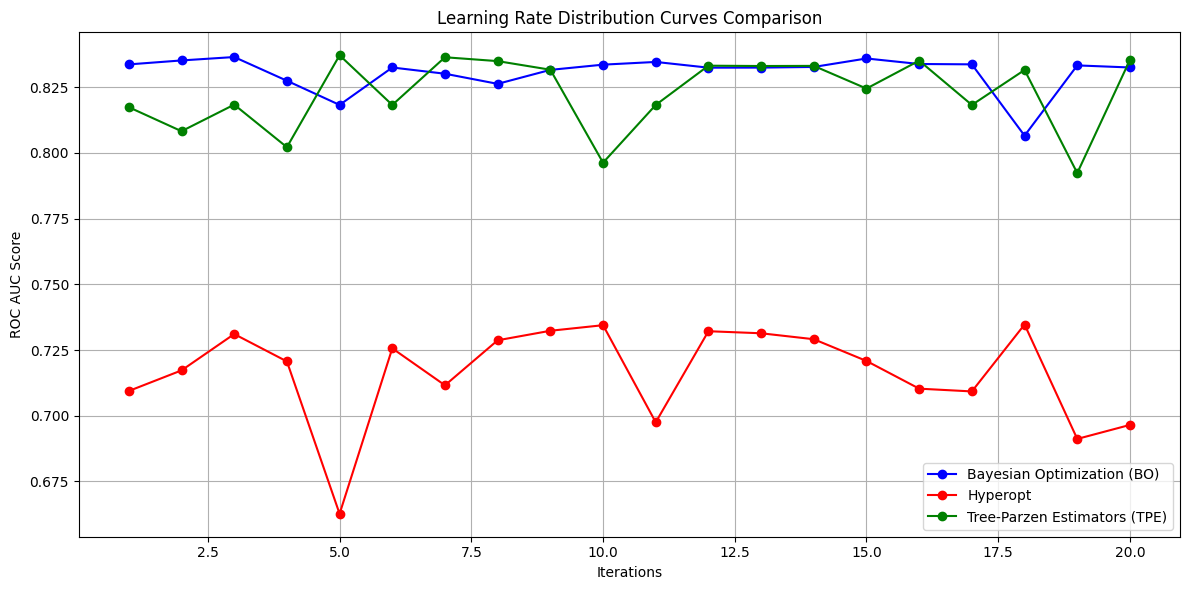

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from skopt import gp_minimize
from hyperopt import fmin, hp, tpe, Trials

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the model and objective function for Bayesian Optimization (BO)
def objective_function_bo(params):
    model = RandomForestClassifier(
        n_estimators=int(params[0]),
        max_depth=int(params[1]),
        min_samples_split=params[2],
        random_state=42,
        n_jobs=-1
    )
    
    # Cross-validation with StratifiedKFold
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    roc_auc_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='roc_auc')
    mean_roc_auc = np.mean(roc_auc_scores)
    
    return -mean_roc_auc  # Minimize negative ROC AUC (BO maximizes)

# Define the search space for Bayesian Optimization (BO)
space_bo = [
    (10, 1000),      # n_estimators
    (2, 20),         # max_depth
    (2, 50)          # min_samples_split
]

# Perform Bayesian Optimization (BO)
res_gp_bo = gp_minimize(objective_function_bo, space_bo, n_calls=20, random_state=42)

# Extract best ROC AUC scores found by Bayesian Optimization (BO)
best_score_bo  = {
    'n_estimators': res_gp_bo.x[0],
    'max_depth': res_gp_bo.x[1],
    'min_samples_split': res_gp_bo.x[2]
}
roc_auc_scores_bo = [-result for result in res_gp_bo.func_vals]
roc_auc_scores_bo

# Plot learning rate distribution curves
plt.figure(figsize=(12, 6))

# Plot Bayesian Optimization (BO)
plt.plot(np.arange(1, len(roc_auc_scores_bo)+1), roc_auc_scores_bo, marker='o', label='Bayesian Optimization (BO)', color='blue')

# Plot hyperopt
plt.plot(np.arange(1, len(roc_auc_scores_hyperopt)+1), roc_auc_scores_hyperopt, marker='o', label='Hyperopt', color='red')

# Plot Tree-Parzen Estimators (TPE)
plt.plot(np.arange(1, len(roc_auc_scores_tpe)+1), roc_auc_scores_tpe, marker='o', label='Tree-Parzen Estimators (TPE)', color='green')

plt.xlabel('Iterations')
plt.ylabel('ROC AUC Score')
plt.title('Learning Rate Distribution Curves Comparison')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
